#### Exercise instructions

This is the template for the third exercise. The purpose of this exercise is to familiarize yourself with the basics of unsupervised learning by using the agglomerative hierarchical clustering and k-means clustering algorithms to find patterns.

This exercise uses the seeds dataset, available on moodle as `seeds.csv`. The features are all numeric. They quantify the measurements related to the geometrical properties of wheat grains. The feature names are listed in the table below.

| Feature | Type 
| :--- | ---: 
| Area | Numeric (float)
| Perimeter | Numeric (float)
| Compactness | Numeric (float)
| Length | Numeric (float)
| Width | Numeric (float)
| Asymmetry Coefficient | Numeric (float)
| Length Groove | Numeric (float)

<br>


In real applications, visualizing various aspects of the data the data and data scrubbing are important steps. However, in this exercise you can treat the data as given, and focus on the unsupervised methods. **REMEMBER, this step can never be neglected in the real world.** <br><br>
___

#### Library imports, Jupyter Notebook settings etc.

The below libraries are sufficient to complete the exercise. You can import additional modules here if you want.

In [124]:
import itertools # has some utilities that may be useful in the exercise

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import seaborn as sns


# IPython magic command to display matplotlib figures together with the output
# (Often the default setting in a Jupyter Notebook context, so your figures probably work fine without it)
%matplotlib inline

### Part 0: Read the data

- Download the exercise 3 data on the **Moodle** page of this course. (`seeds.csv`)
- Read the data into a Pandas dataframe.
- Display a few rows and some basic information to make sure the data was loaded correctly

In [6]:
# YOUR CODE
file_path = 'seeds.csv'

seeds_dataframe = pd.read_csv(file_path)

print("Dataset:")
print(seeds_dataframe.head())

print("\nDataset Info:")
print(seeds_dataframe.info())

print("\nDataset Summary:")
print(seeds_dataframe.describe())


Dataset:
    area  perimeter  compactness  length  width  asymmetry_coef  length_groove
0  18.45      16.12       0.8921   6.107  3.769           2.235          5.794
1  11.41      12.95       0.8560   5.090  2.775           4.957          4.825
2  10.79      12.93       0.8107   5.317  2.648           5.462          5.194
3  18.14      16.12       0.8772   6.059  3.563           3.619          6.011
4  15.38      14.90       0.8706   5.884  3.268           4.462          5.795

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            210 non-null    float64
 1   perimeter       210 non-null    float64
 2   compactness     210 non-null    float64
 3   length          210 non-null    float64
 4   width           210 non-null    float64
 5   asymmetry_coef  210 non-null    float64
 6   length_groove   210 non-null    f

### Part 1: Preprocess and visualize the data

 - Perform z-score standardization on the features to ensure that all features have the same scale.
 - Explain briefly why this is important.
 - For visualization, project the data to two dimensions by using principal component analysis (PCA).
 - **These PCs are solely used for plotting the data.** The clusterings are done on the original standardized features.

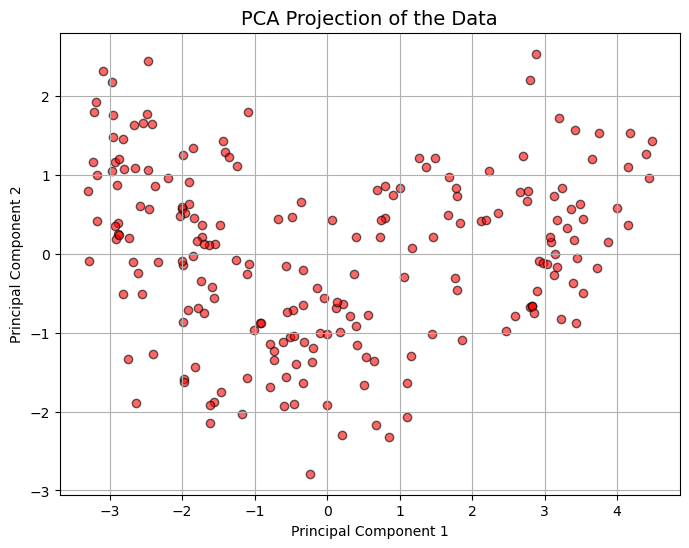

In [14]:
# YOUR CODE
# applying z-score standardization
scaler = StandardScaler()
standardized_features = scaler.fit_transform(seeds_dataframe)

# applying principal component analysis (PCA)
pca = PCA(n_components=2) 
principal_components = pca.fit_transform(standardized_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# plotting PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='red', alpha=0.6, edgecolor='k')
plt.title('PCA Projection of the Data', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

<div style="color: skyblue;">
Z-score standardization makes sure that all features have an average value of 0 and a standard deviation of 1. This is important for features with larger ranges such as area, perimeter etc. so that it doesn't dominate features with smaller ranges such as compactness, asymmetry_coef etc during PCA and clustering. This makes the results more meaningful and unbiased.

 - Visualize the resulting two-dimensional data in a scatter plot.
 - Does it look like there are clear clusters? Don't worry if they're hard to see. There may be more than one "correct" answer.
 - Draw shapes (for example `matplotlib.patches.Ellipse`) on top of the scatter plot to visualize any clusters you feel you can easily detect.

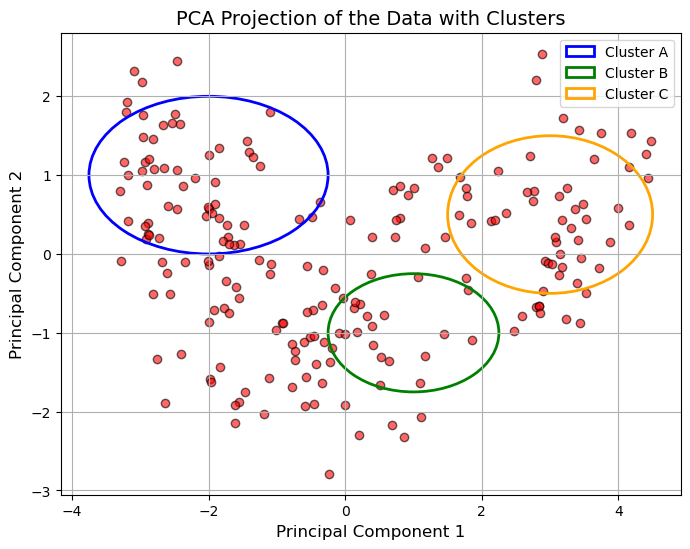

In [10]:
# YOUR CODE
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='red', alpha=0.6, edgecolor='k')
plt.title('PCA Projection of the Data with Clusters', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Source: 
#### https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Ellipse.html
# adding shapes to display clusters
ax = plt.gca()

ellipse1 = Ellipse(xy=(-2, 1), width=3.5, height=2, edgecolor='blue', facecolor='none', linewidth=2, label='Cluster A')
ellipse2 = Ellipse(xy=(1, -1), width=2.5, height=1.5, edgecolor='green', facecolor='none', linewidth=2, label='Cluster B')
ellipse3 = Ellipse(xy=(3, 0.5), width=3, height=2, edgecolor='orange', facecolor='none', linewidth=2, label='Cluster C')

ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

plt.legend(loc='upper right')
plt.grid(True)
plt.show()

<div style="color: skyblue;">
The scatter plot shows three clusters, with Cluster A (blue) in the top-left, Cluster B (green) near the center-bottom, and Cluster C (orange) on the right. While some separation is visible, overlaps between clusters suggest noise or shared characteristics, making the clusters somewhat ambiguous. 

### Part 2a: Agglomerative hierarchical clustering theory
Explain briefly the different linkage criterion values.

### Source: https://medium.com/@iqra.bismi/different-linkage-methods-used-in-hierarchical-clustering-627bde3787e8
- Single: <p style="color: skyblue;">Single linkage, also known as nearest neighbor linkage, determines the distance between two clusters as the shortest distance between any two points in the two clusters. In other words, the distance between two clusters is defined by the distance between their closest points. This method tends to produce long, chain-like clusters that are sensitive to outliers and noise in the data</p>
- Average: <p style="color: skyblue;">Average linkage determines the distance between two clusters as the average distance between all pairs of points in the two clusters. This method tends to produce clusters that are somewhere between the long, chain-like clusters produced by single linkage and the compact, spherical clusters produced by complete linkage.</p>
- Complete: <p style="color: skyblue;">Complete linkage, also known as farthest neighbor linkage, determines the distance between two clusters as the longest distance between any two points in the two clusters. In other words, the distance between two clusters is defined by the distance between their farthest points. This method tends to produce compact, spherical clusters that are less sensitive to outliers and noise in the data.</p>
- Ward: <p style="color: skyblue;">Ward linkage, also known as minimum variance linkage, determines the distance between two clusters by minimising the increase in variance when the two clusters are merged. This method tends to produce clusters that have similar variances and sizes.</p>

Explain the **silhouette coefficient** (silhouette_score).

### Source: https://medium.com/@hazallgultekin/what-is-silhouette-score-f428fb39bf9a
<div style="color: skyblue;">
The silhouette coefficient is a metric used to evaluate the quality of clustering by measuring how well each data point fits within its own cluster compared to other clusters. It considers two key factors: cohesion, which is the average distance between a point and all other points within the same cluster, and separation, which is the average distance between a point and all points in the nearest neighboring cluster. The coefficient ranges from -1 to 1, where a value close to 1 indicates that the point is well-clustered, a value near 0 suggests it is on the boundary between clusters, and a value close to -1 means the point may be misclassified. A higher silhouette score signifies better-defined and well-separated clusters.

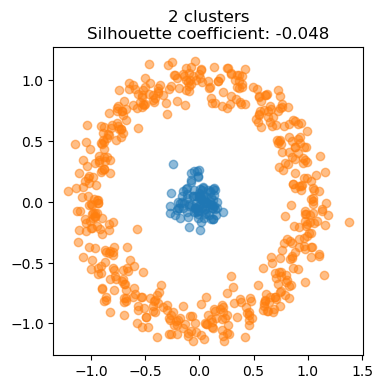

In [23]:
n = 2
no_in = 100
no_out = 500
labels = np.concatenate((np.zeros(no_in), np.ones(no_out)))

inner_cluster = np.random.randn(no_in, 2)*0.1
theta = np.linspace(0, 2*np.pi, no_out)
outer_cluster = np.array([np.cos(theta), np.sin(theta)]).T + np.random.randn(no_out, 2)*0.1
data = np.vstack((inner_cluster, outer_cluster))

score = silhouette_score(data, labels)

plt.figure(figsize=(4, 4))
plt.title(f'{n} clusters\nSilhouette coefficient: {score:.3f}')
for c in range(n):
    plt.scatter(data[labels==c, 0], data[labels==c, 1], alpha=0.5)
    
plt.show()

In the figure above, why is the silhouette coefficient close to zero even though the clusters are clearly distinct?
 
(Optional) What would be a better way to assess this clustering?

 <div style="color: skyblue;">
It is because the clusters have a complicated structure. While the two groups look distinct, the points inside each cluster are not well-separated when the silhouette coefficient is calculated. This can happen if the clusters are circular, overlap, or have uneven densities, causing points at the edges of the clusters to have similar distances to both other points in the same cluster and points in nearby clusters.

### Part 2b: Agglomerative hierarchical clustering practice

Let's get back to the **seeds** dataset.

Cluster the standardized data into 2-10 clusters using agglomerative hierarchical clustering.
- Explore all combinations of the **number of clusters** (2-10) and the **linkage criteria**.
- Calculate the silhouette coefficient for each combination and store the results, as well as the predictions made by the clustering.

*Tip: you can use `itertools.product` function to get the Cartesian product of the two lists of hyperparameters (number of clusters, linkage criterion)*

In [38]:
# YOUR CODE

n_clusters_range = list(range(2, 11))
linkage_criteria = ['single', 'average', 'complete', 'ward']

# Source:
#### https://www.geeksforgeeks.org/python-itertools-product/
#### https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/
param_combinations = list(itertools.product(n_clusters_range, linkage_criteria))

# list to store results
results = []

for n_clusters, linkage in param_combinations:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    cluster_labels = model.fit_predict(standardized_features)
    
    silhouette_avg = silhouette_score(standardized_features, cluster_labels)
    
    results.append({
        'n_clusters': n_clusters,
        'linkage': linkage,
        'silhouette_score': silhouette_avg,
        'cluster_labels': cluster_labels
    })
    
# printing best combination of n_clusters and linkage criterion with highest score
results = results_df.loc[results_df['silhouette_score'].idxmax()]
print("\nBest Result:")
print(results)


Best Result:
n_clusters                                                          2
linkage                                                          ward
silhouette_score                                             0.461297
cluster_labels      [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, ...
Name: 3, dtype: object


- Use the silhouette score to determine the best linkage criterion for each number of clusters (2-10).
- For each number of clusters, display the best linkage criterion and the silhouette score, sorted by the score (high to low) as follows:

| Number of clusters | Linkage criterion | Silhouette score
| --- | --- | ---   

In [66]:
# YOUR CODE
bst_linkage_per_clstr = results_df.loc[results_df.groupby('n_clusters')['silhouette_score'].idxmax()].sort_values(by='silhouette_score', ascending=False)
print(bst_linkage_per_clstr[['n_clusters', 'linkage', 'silhouette_score']])

    n_clusters   linkage  silhouette_score
3            2      ward          0.461297
7            3      ward          0.392634
9            4   average          0.354864
14           5  complete          0.293720
17           6   average          0.290306
29           9   average          0.279423
25           8   average          0.270292
21           7   average          0.268883
33          10   average          0.257456


 - Plot four clusterings with **three clusters**, one of each **linkage criterion**, as scatter plots.
 - Again, use the first two PCs for visualization. 
 - Colour the datapoints according to the clusters they were assigned to.
 - The structure of the plot is provided

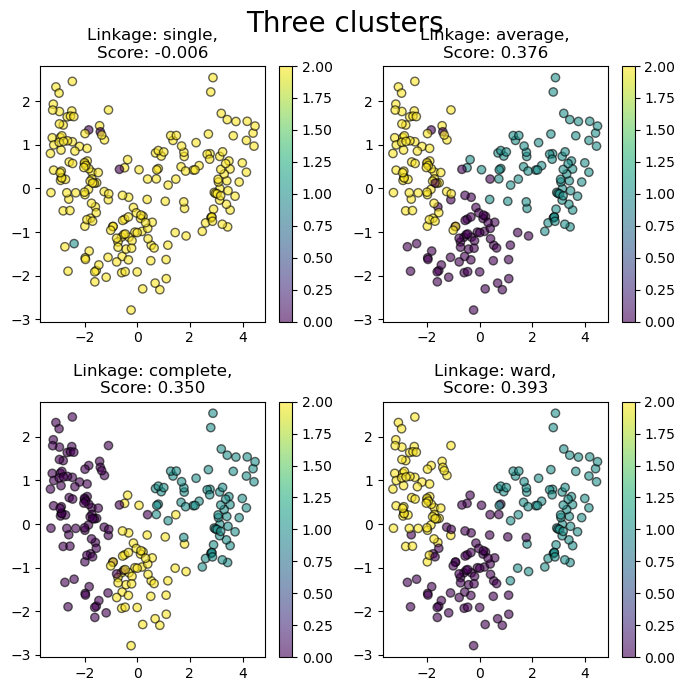

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
fig.suptitle("Three clusters", fontsize=20)

# Source:
#### https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

for i, ax in enumerate(axes.flat): 
    model = AgglomerativeClustering(n_clusters=3, linkage=linkage_criteria[i])
    cluster_labels = model.fit_predict(standardized_features)
    
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolor='k')
    
    silhouette_avg = silhouette_score(standardized_features, cluster_labels)
    ax.set_title(f"Linkage: {linkage_criteria[i]},\nScore: {silhouette_avg:.3f}")
    
    fig.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

 - Similarly, from the clusterings using **'ward'** linkage criterion, plot the four clusterings of best performing **number of clusters** as scatter plots.

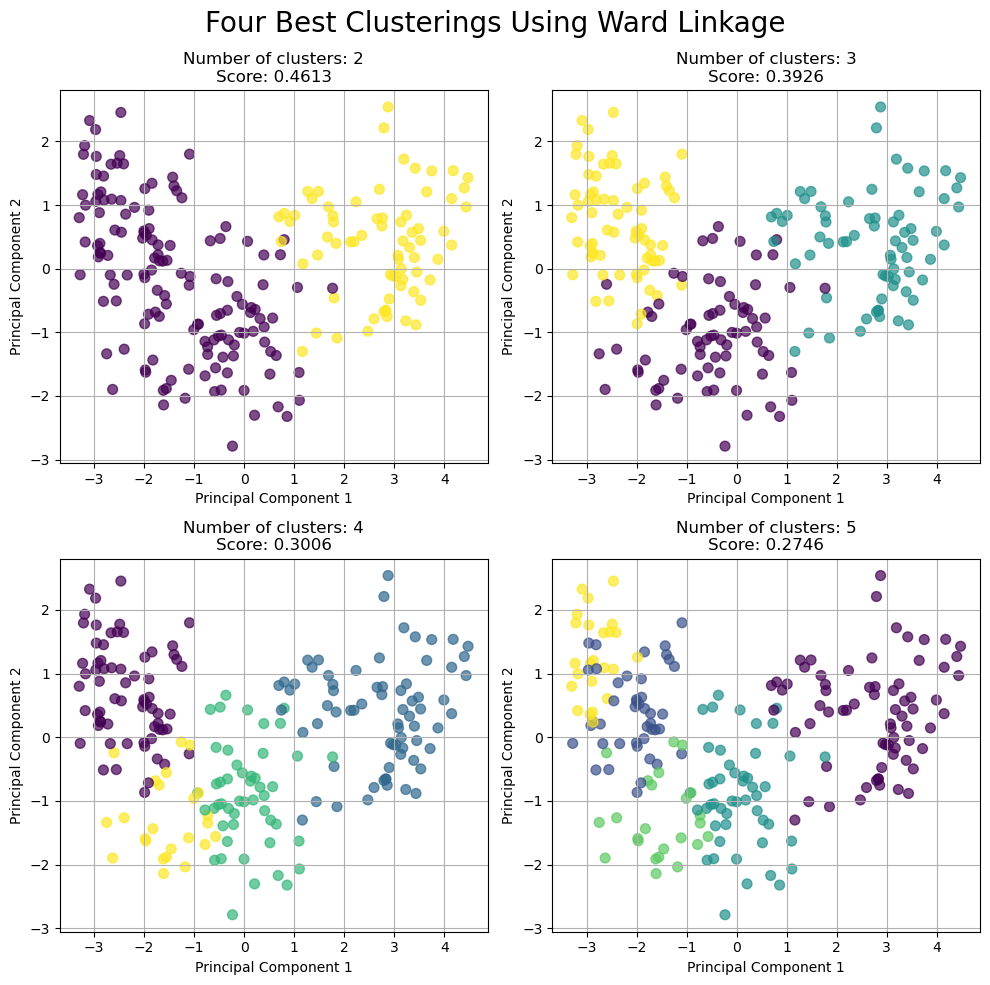

In [98]:
# filtering results for 'ward' linkage
best_ward_results = results_df[results_df['linkage'] == 'ward']
best_ward_results_sorted = best_ward_results.sort_values(by='silhouette_score', ascending=False)

# Get the top 4 best performing numbers of clusters based on silhouette score
best_n_clusters_ward = best_ward_results_sorted.head(4)['n_clusters'].values

ward_cluster_labels = {}

for n_clusters in best_n_clusters_ward:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(standardized_features)  # X_scaled should be your standardized data
    ward_cluster_labels[n_clusters] = labels

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Four Best Clusterings Using Ward Linkage", fontsize=20)

axes = axes.flatten()

# Iterate over the best cluster counts and plot each
for i, ax in enumerate(axes):
    n_clusters = best_n_clusters_ward[i]
    labels = ward_cluster_labels[n_clusters]
    
    ax.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    
    silhouette_score_value = best_ward_results_sorted[best_ward_results_sorted['n_clusters'] == n_clusters]['silhouette_score'].values[0]
    ax.set_title(f"Number of clusters: {n_clusters}\nScore: {silhouette_score_value:.4f}")
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

Think about the clusters you see and how the choice of the linkage criterion and the number of clusters affected the formation of clusters. No need to write an answer.

Do some of the clusterings discovered by agglomerative hierarchical clustering correspond to what visually looked like clusters to you in Part 1? Which ones? It's absolutely fine if they don't.

<div style="color: skyblue;">
The clusters found by using the Ward linkage method somewhat align with the clusters in the first part. Furthermore, this clustering shows groups that look similar to the ones seen earlier, especially with 2 or 3 clusters, which makes sense based on the visual separation in the data. However, there are a few differences in how the clusters are grouped, which suggests that the algorithm might not always match exactly what we see visually, but still captures the main structure of the data.

### Part 3: _k_-means clustering

- Perform _k_-means clustering on the standardized data. Try 2-10 numbers of clusters.
- Evaluate the clustering performance using the silhouette coefficient.
- Store the centroids of the clusters

In [147]:
# YOUR CODE

# Sources:
#### https://www.w3schools.com/python/python_ml_k-means.asp

# List to store results (silhouette scores and centroids)
kmeans_results = []

# Perform k-means clustering for numbers of clusters from 2 to 10
for n_clusters in range(2, 11):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_predictions = kmeans.fit_predict(standardized_features)
    
    # Calculate silhouette score
    sil_score = silhouette_score(standardized_features, cluster_predictions)
    
    # Store the results
    kmeans_results.append({
        'n_clusters': n_clusters,
        'silhouette_score': sil_score,
        'centroids': kmeans.cluster_centers_,
        'cluster_predictions': cluster_predictions
    })

# Convert results to DataFrame for easy analysis
kmeans_results_df = pd.DataFrame(kmeans_results)

# Display the silhouette scores and centroids
print(kmeans_results_df[['n_clusters', 'silhouette_score']])

   n_clusters  silhouette_score
0           2          0.461466
1           3          0.400727
2           4          0.332575
3           5          0.277236
4           6          0.282878
5           7          0.271037
6           8          0.258722
7           9          0.246891
8          10          0.226432


C:\Users\Junaid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Junaid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Junaid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Junaid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Wi

 - Choose the four best numbers of clusters according to silhouette coefficient that you discovered above.
 - Once again visualize them on a scatter plot of the first two principal components.
 - Display the centroids of the clusters on the plot.
 - Remember to transform the centroids to the PCA space.
 - Explain why you need to transform the centroids.

<div style="color: skyblue;">
Transforming the centroids ensures that they are aligned with the data points when we plot them in the PCA space. K-means clustering groups the data based on its original features while in PCA the data is reduced into two main important dimensions in order to make the plotting easier. To show the centroids in the plot, we need to transform them from the original features into the new 2D space. If we don't do this, the centroids will not appear in the right place on the plot because they were calculated using the original features, not the reduced 2D space.

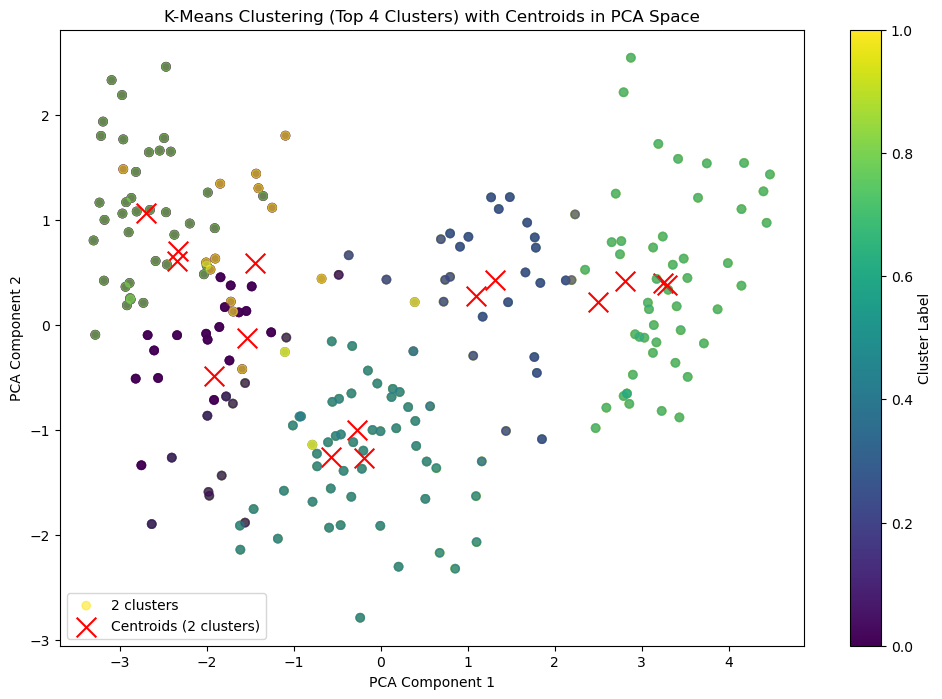

In [144]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


# Selecting 4 cluster with highest silhouette scores
top_clusters = kmeans_results_df.nlargest(4, 'silhouette_score')

pca = PCA(n_components=2)
pca_features = pca.fit_transform(standardized_features)

plt.figure(figsize=(12, 8))

for index, row in top_clusters.iterrows():
    n_clusters = row['n_clusters']
    cluster_predictions = row['cluster_predictions']
    centroids = row['centroids']
    
    # transforming centroids to PCA space
    centroids_pca = pca.transform(centroids)
    
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_predictions, cmap='viridis', alpha=0.6, label=f'{n_clusters} clusters' if index == 0 else "")
    
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, c='red', label=f'Centroids ({n_clusters} clusters)' if index == 0 else "")

plt.title('K-Means Clustering (Top 4 Clusters) with Centroids in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.legend(loc='best')
plt.colorbar(label='Cluster Label')
plt.show()


### Part 4 (BONUS): Filling in missing labels using clustering

In this bonus exercise, you're given a dataset with almost all of the labels missing. This is the starting point in semi-supervised learning. Semi-supervised learning in general is beyond the scope of this course, but if you want you can learn more about it, starting e.g. on [the sklearn page for semi-supervised learning](https://scikit-learn.org/stable/modules/semi_supervised.html). **This exercise does not require researching semi-supervised learning, however.**

The dataset used in this exercise is a slightly modified version of [the wine dataset](https://archive.ics.uci.edu/dataset/109/wine). The features quantify chemical properties of wine, grown around the same area in Italy. They are divided to three different classes, simply called `1`, `2` and `3` here. The feature names and their data types are listed in the table below. **Use the modified dataset on Moodle, with the filename `wine_missing_labels.csv`**


| Feature | Type 
| :--- | ---: 
| Alcohol | Numeric (float)
| Malic acid | Numeric (float)
| Ash | Numeric (float)
| Alcalinity of ash | Numeric (float)
| Magnesium | Numeric (integer)
| Total phenols | Numeric (float)
| Flavanoids | Numeric (float)
| Nonflavanoid phenols | Numeric (float)
| Proanthocyanins | Numeric (float)
| Color intensity | Numeric (float)
| Hue | Numeric (float)
| OD280/OD315 of diluted wines | Numeric (float)
| Proline | Numeric (integer)

<br>

First, visualize the first two principal components of the dataset in a scatter plot, showing the labels real for data points you were given. Try to see if the labels look like they belong in what look like clusters on the plot.

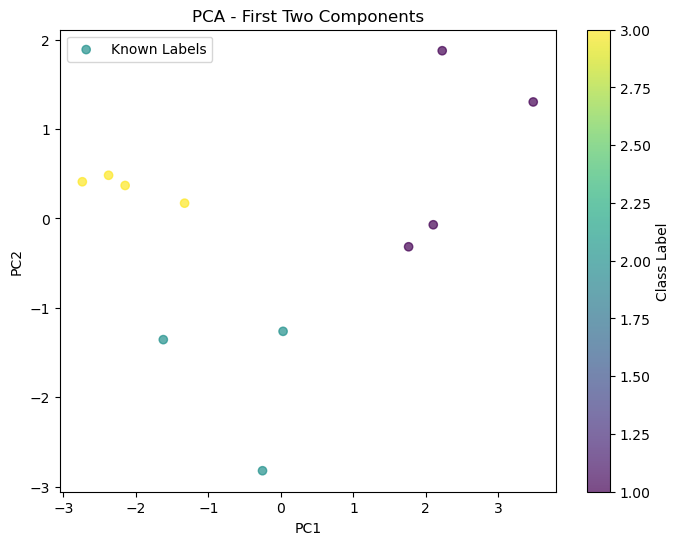

In [186]:
# YOUR CODE
data = pd.read_csv("wine_missing_labels.csv")

# separating the features and the labels for PCA
X = data.drop(columns=['Label'], errors='ignore')
y = data['Label'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))

# For this logic I have used AI because i was confused if i need to point out all the dataset in PCA with known or unknown labels or just visualise how distinct the cluster looks 
if y is not None:
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y, cmap='viridis', label='Known Labels', alpha=0.7)
    plt.colorbar(label='Class Label')  
    
else:
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', label='Unlabeled Data', alpha=0.6)

plt.title('PCA - First Two Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.show()


<div style="color: skyblue;">
As we can see from the plot, the clusters are well-separated and distinct which represents that the labels are well-defined and that these clusters correspond to the true classes. 

Your task is to use clustering to assign labels to the rows that have a missing value as their label. Do this by first clustering all of the data, and then filling in the missing labels based on which clusters the data points with known labels tend to fit in. 

Use whichever clustering methods you prefer. You can cluster the data into 3 clusters because you have 3 known labels, but you could also try a higher number of clusters that you can then merge.

The details of how exactly you decide which rows get assigned which label are up to you - you can get creative. Describe and justify your thought process.

<br>

You are also given the full labels for the dataset in a separate file called `wine_labels.csv`. Plot the real labels next to the labels that your clustering attempts predicted.

Finally, compute the adjusted Rand index for labels predicted by your clustering solutions and the real labels, and display it along the scatter plots. Rand index is a measure of similarity between two partitions of a set of elements. Adjusted Rand index is corrected for chance using the maximum and expected values of Rand index. Optionally, you can learn more about the Rand index e.g. on [the Wikipedia page for Rand index](https://en.wikipedia.org/wiki/Rand_index). Here you can simply use the `sklearn.metrics.adjusted_rand_score` method imported at the beginning of this notebook without further understanding of it. 

*Hint: you should get something over 0.8*

C:\Users\Junaid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


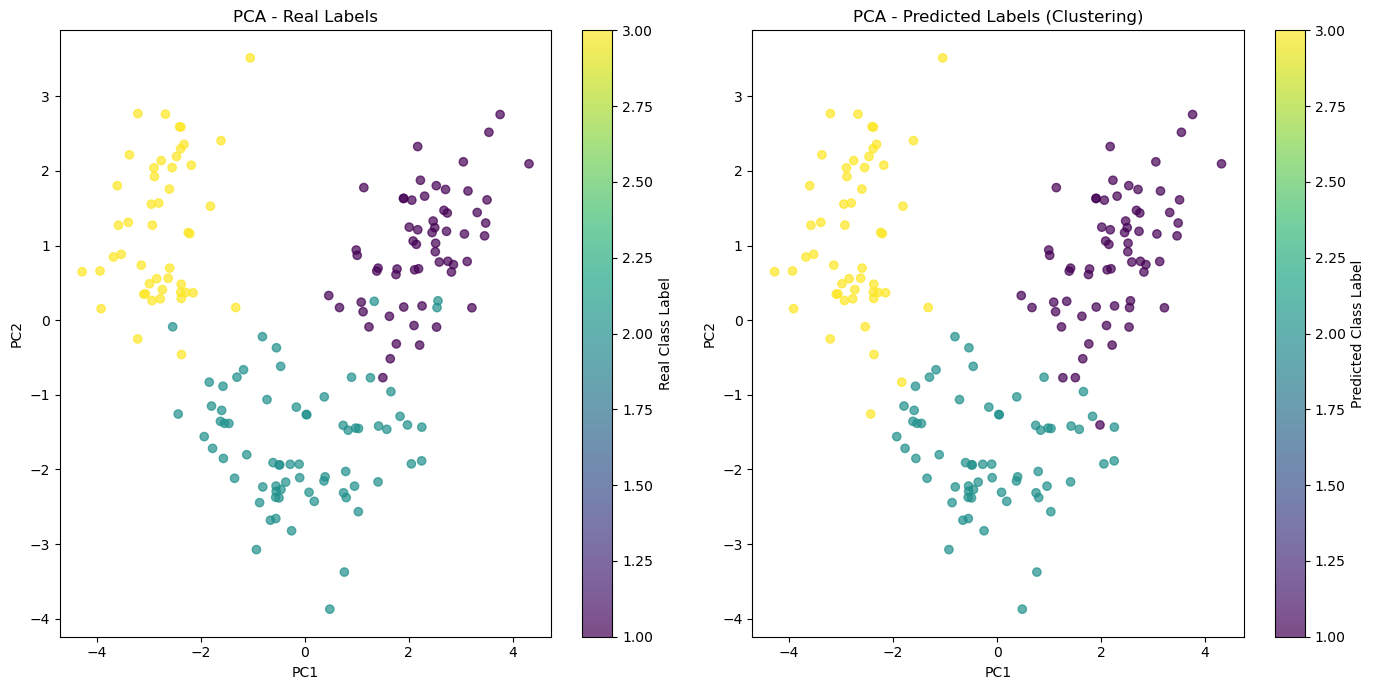

Adjusted Rand Index: 0.8636


In [188]:
data = pd.read_csv("wine_missing_labels.csv")
labels = pd.read_csv("wine_labels.csv")

X = data.drop(columns=['Label'], errors='ignore') 
y_real = labels['Label'] 

# Step 3: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Apply KMeans clustering to the entire dataset
n_clusters = 3  # We know there are 3 real labels
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_scaled)

# Use of AI for this method too because initially i was getting a negative RAND index value
def assign_labels_to_clusters(y_pred, known_labels):
    cluster_labels = {}
    for cluster in np.unique(y_pred):
        # Get the most frequent label in each cluster
        labels_in_cluster = known_labels[y_pred == cluster]
        most_frequent_label = labels_in_cluster.mode()[0]  # Get the most frequent label
        cluster_labels[cluster] = most_frequent_label
    return np.array([cluster_labels[cluster] for cluster in y_pred])

y_pred_labels = assign_labels_to_clusters(y_pred, y_real)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Real Labels'] = y_real
pca_df['Predicted Labels'] = y_pred_labels

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Real Labels'], cmap='viridis', alpha=0.7)
plt.title('PCA - Real Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Real Class Label')

plt.subplot(1, 2, 2)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Predicted Labels'], cmap='viridis', alpha=0.7)
plt.title('PCA - Predicted Labels (Clustering)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Predicted Class Label')

plt.tight_layout()
plt.show()

ari_score = adjusted_rand_score(y_real, y_pred_labels)
print(f"Adjusted Rand Index: {ari_score:.4f}")

<div style="color: skyblue;">
Now that we have the Rand Index score of 0.86, it indicates a strong alignment between the predicted labels and the real labels. This result suggests that the clustering algorithm successfully grouped data points in a way that reflects the true classes.